In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.tensorboard import SummaryWriter

In [2]:
class MyData(Dataset):
  def __init__(self, data, window_size):
    self.data = data
    self.window_size = window_size

    self.X, self.y = self.create_sequences()

  def create_sequences(self):
    X_data, y_data = [], []
    for i in range(self.data.shape[0] - self.window_size):
      window = self.data[i:(i+self.window_size)]
      label = self.data[i+self.window_size]

      X_data.append(window)
      y_data.append(label)

    return np.array(X_data), np.array(y_data)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return(torch.from_numpy(self.X[idx]).float(),
           torch.from_numpy(self.y[idx]).float())

In [3]:
class LSTM(nn.Module):
  def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
    super(LSTM, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.linear = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    #init hidden state and the cell state
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

    out, (hn, cn) = self.lstm(x, (h0, c0))
    out = self.linear(out[:, -1, :]) #output

    return out

In [43]:
class Trainer:
  def __init__(self, model, train_loader, val_loader, test_loader, criterion, optimizer, epoch_num=100):
    self.model = model
    self.train_loader = train_loader
    self.val_loader = val_loader
    self.test_loader = test_loader
    self.criterion = criterion
    self.optimizer = optimizer
    self.epoch_num = epoch_num

    self.train_losses = []
    self.val_losses = []

    self.device = "cuda" if torch.cuda.is_available() else "cpu"
    self.model.to(self.device)
    print(f"Model using device {self.device}\n")

  def fit(self):
    for epoch in range(self.epoch_num):
      train_loss = self.train()
      val_loss, _, _ = self.evaluate(self.val_loader)

      self.train_losses.append(train_loss)
      self.val_losses.append(val_loss)

      print(f'Epoch [{epoch+1}/{self.epoch_num}], train loss: {train_loss:.6f}, Val loss: {val_loss:.6f}')

  def train(self):
    self.model.train()
    total_loss = 0

    for X_batch, y_batch in self.train_loader:
      X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)

      self.optimizer.zero_grad()
      y_pred = self.model(X_batch)
      loss = self.criterion(y_pred, y_batch)
      loss.backward()
      self.optimizer.step()
      total_loss += loss.item()

    return total_loss / len(self.train_loader)

  @torch.no_grad()
  def evaluate(self, loader):
    self.model.eval()
    total_loss = 0
    predictions = []
    actuals = []

    for X_batch, y_batch in loader:
      X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)

      y_pred = self.model(X_batch)
      loss = self.criterion(y_pred, y_batch)
      total_loss += loss.item()

      predictions.append(y_pred.cpu().numpy())
      actuals.append(y_batch.cpu().numpy())

    avg_loss = total_loss / len(loader)
    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)

    return avg_loss, predictions, actuals

In [5]:
df = sns.load_dataset("flights")
data_series = df['passengers'].values.astype(float)
print(df.head())
data_series

   year month  passengers
0  1949   Jan         112
1  1949   Feb         118
2  1949   Mar         132
3  1949   Apr         129
4  1949   May         121


array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
       118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
       114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
       162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
       209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
       272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
       302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
       315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
       318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
       348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
       362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
       342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
       417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
       432.])

In [22]:
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data_series.reshape(-1,1))

In [23]:
total_size = len(data_scaled)
train_size = int(total_size * 0.7)
val_size = int(total_size * 0.15)
test_size = total_size - train_size - val_size

train_data = data_scaled[:train_size]
val_data = data_scaled[train_size:train_size + val_size]
test_data = data_scaled[train_size + val_size:]

print(f"Total data size: {total_size}")
print(f"Train data size: {len(train_data)}")
print(f"Validation data size: {len(val_data)}")
print(f"Test data size: {len(test_data)}")

Total data size: 144
Train data size: 100
Validation data size: 21
Test data size: 23


In [42]:
WINDOW_SIZE = 10
BATCH_SIZE = 5

train_dataset = MyData(train_data, WINDOW_SIZE)
val_dataset = MyData(val_data, WINDOW_SIZE)
test_dataset = MyData(test_data, WINDOW_SIZE)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train loader batches: {len(train_loader)}")
print(f"Validation loader batches: {len(val_loader)}")
print(f"Test loader batches: {len(test_loader)}")

Train loader batches: 18
Validation loader batches: 3
Test loader batches: 3


In [44]:
model = LSTM(input_size=1, hidden_size=64, num_layers=2, output_size=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

trainer = Trainer(model, train_loader, val_loader, test_loader, criterion, optimizer, epoch_num=100)

print("Start training")
trainer.fit()
print("training done")

Model using device cpu

Start training
Epoch [1/100], train loss: 0.038803, Val loss: 0.067158
Epoch [2/100], train loss: 0.019059, Val loss: 0.089865
Epoch [3/100], train loss: 0.017025, Val loss: 0.079404
Epoch [4/100], train loss: 0.014672, Val loss: 0.031437
Epoch [5/100], train loss: 0.009578, Val loss: 0.020890
Epoch [6/100], train loss: 0.007049, Val loss: 0.021675
Epoch [7/100], train loss: 0.006222, Val loss: 0.018491
Epoch [8/100], train loss: 0.005912, Val loss: 0.017047
Epoch [9/100], train loss: 0.006429, Val loss: 0.016162
Epoch [10/100], train loss: 0.005571, Val loss: 0.017446
Epoch [11/100], train loss: 0.005799, Val loss: 0.015599
Epoch [12/100], train loss: 0.005589, Val loss: 0.015260
Epoch [13/100], train loss: 0.005372, Val loss: 0.015350
Epoch [14/100], train loss: 0.006369, Val loss: 0.018293
Epoch [15/100], train loss: 0.005802, Val loss: 0.019290
Epoch [16/100], train loss: 0.005207, Val loss: 0.016728
Epoch [17/100], train loss: 0.005121, Val loss: 0.016428
E

In [45]:
print("Evaluating on Test set...")
test_loss, test_pred, test_actual = trainer.evaluate(test_loader)

# Re-fit scaler to ensure we can inverse transform (in case variable was lost)
# Using data_series from kernel state
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(data_series.reshape(-1,1))

# Inverse transform
test_pred_unscaled = scaler.inverse_transform(test_pred)
test_actual_unscaled = scaler.inverse_transform(test_actual)

print(f"Test Loss (MSE): {test_loss:.6f}")
print(f"First 5 Predictions: {test_pred_unscaled[:5].flatten()}")
print(f"First 5 Actuals: {test_actual_unscaled[:5].flatten()}")

Evaluating on Test set...
Test Loss (MSE): 0.033086
First 5 Predictions: [271.95657 411.55872 355.9559  364.44482 422.21228]
First 5 Actuals: [405.00003 417.      391.00003 419.      461.00003]


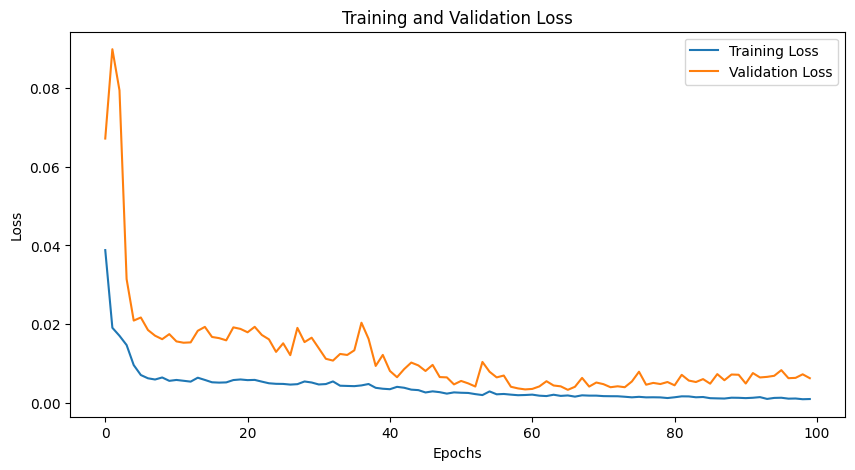

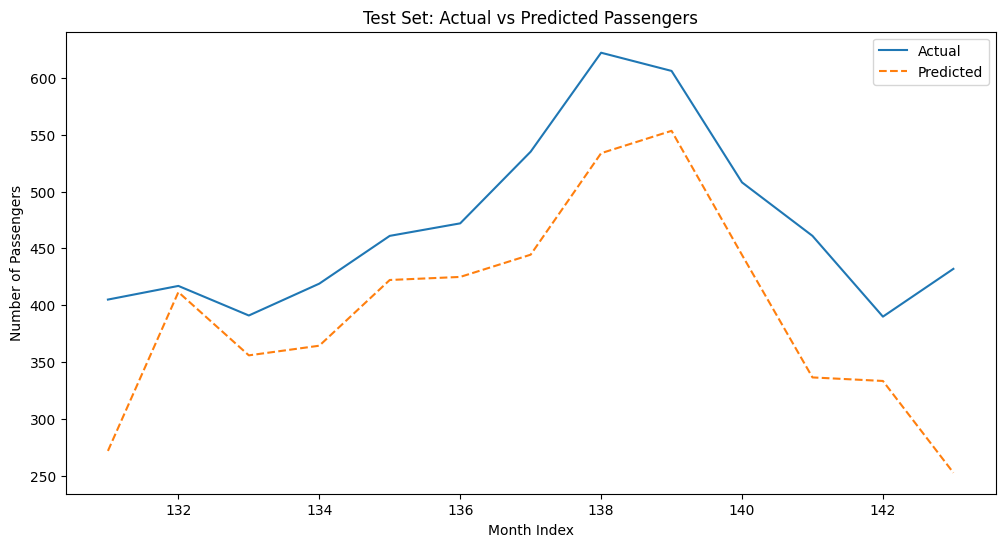

In [46]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(trainer.train_losses, label='Training Loss')
plt.plot(trainer.val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Calculate indices for the test data predictions
# Test data starts at train_size + val_size
# The first prediction corresponds to the (WINDOW_SIZE)th element of the test data sequence
# Global index: (train_size + val_size) + WINDOW_SIZE
total_train_val_size = train_size + val_size
test_start_index = total_train_val_size + WINDOW_SIZE
test_plot_indices = np.arange(test_start_index, total_size)

# Plot Actual vs Predicted for Test Set
plt.figure(figsize=(12, 6))
plt.plot(test_plot_indices, test_actual_unscaled.flatten(), label='Actual')
plt.plot(test_plot_indices, test_pred_unscaled.flatten(), label='Predicted', linestyle='--')
plt.title('Test Set: Actual vs Predicted Passengers')
plt.xlabel('Month Index')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()